In [1]:
import theano
import theano.tensor as T
import lasagne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5005)


In [41]:
activation = lasagne.nonlinearities.tanh
number_of_neurons = 500
init = lasagne.init.Uniform(range=0.01)
#init = lasagne.init.Normal(mean=0.0, std=np.sqrt(1.0/number_of_neurons)) #Glorot/Xavier
#init = lasagne.init.Normal(mean=0.0, std=np.sqrt(2.0/number_of_neurons)) #He
number_of_layers = 10

#Symbolic vars
input_var = T.dmatrix('inputs')
target_var = T.dmatrix('targets')

#Initialize the network
network = lasagne.layers.InputLayer(shape=(None, number_of_neurons), input_var=input_var)
layers = []

for i in xrange(number_of_layers):
    network = lasagne.layers.DenseLayer(network, 
                                        num_units=number_of_neurons, 
                                        nonlinearity=activation, W=init)
    
network = lasagne.layers.DenseLayer(network, 
                                    num_units=1, 
                                    nonlinearity=lasagne.nonlinearities.sigmoid)

#Get all layers, outputs from every layer and all parameters from layers
layers = lasagne.layers.get_all_layers(network)
outputs = lasagne.layers.get_output(layers)
params = lasagne.layers.get_all_params(network, trainable=True)

#Set up prediction and loss function
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.binary_crossentropy(prediction, target_var)
loss = loss.mean()

#Get gradients and updates
grads = lasagne.updates.get_or_compute_grads(loss, params)

updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

train_fn = theano.function([input_var, target_var], [loss] + outputs + grads, updates=updates)

LOSS: 0.720715
VALUES
input layer has mean -0.001700 and std 0.999282
OUTPUT 1 has mean -0.001277 and std 0.722464
OUTPUT 2 has mean 0.001951 and std 0.634556
OUTPUT 3 has mean -0.001555 and std 0.598320
OUTPUT 4 has mean -0.003137 and std 0.575439
OUTPUT 5 has mean 0.005034 and std 0.567512
OUTPUT 6 has mean 0.005702 and std 0.561647
OUTPUT 7 has mean 0.001428 and std 0.556140
OUTPUT 8 has mean -0.000137 and std 0.556110
OUTPUT 9 has mean -0.000133 and std 0.557403
OUTPUT 10 has mean 0.002811 and std 0.557714
OUTPUT 11 has mean 0.535526 and std 0.176333
GRADIENTS
GRAD 1 has mean 0.000008 and std 0.002558
GRAD 2 has mean 0.000004 and std 0.002225
GRAD 3 has mean -0.000001 and std 0.002071
GRAD 4 has mean 0.000001 and std 0.001867
GRAD 5 has mean -0.000006 and std 0.001771
GRAD 6 has mean 0.000004 and std 0.001706
GRAD 7 has mean 0.000005 and std 0.001616
GRAD 8 has mean 0.000002 and std 0.001500
GRAD 9 has mean 0.000002 and std 0.001450
GRAD 10 has mean -0.000003 and std 0.001464
GRAD 

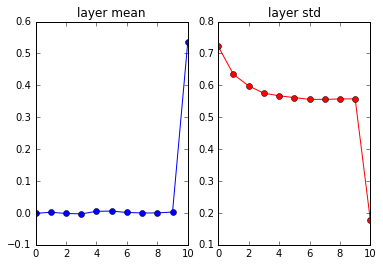

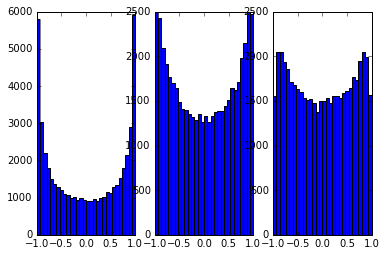

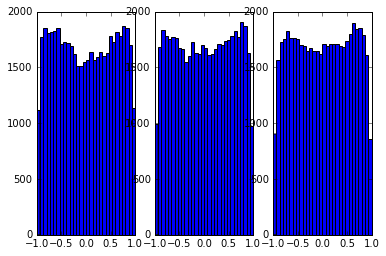

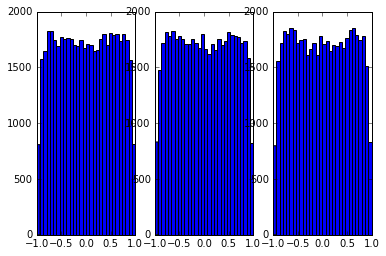

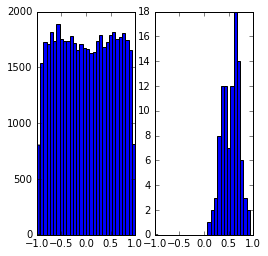

In [42]:
X = np.random.randn(100, 500)
y = np.random.binomial(1, 0.5, size=(100, 1)).astype('float32')

result = train_fn(X, y)

loss = result[0]
print('LOSS: %f' % loss)

out_by_layer = result[1:len(layers)+1]
grad_vals = result[len(layers)+1:]

layer_means = []
layer_stds = []
Hs = {}
print('VALUES')
print('input layer has mean %f and std %f' % (np.mean(X), np.std(X)))
for i, vals in enumerate(out_by_layer[1:]):
    Hs[i] = vals
    layer_means.append(np.mean(vals))
    layer_stds.append(np.std(vals))
    print('OUTPUT %d has mean %f and std %f' % 
          (i+1, layer_means[-1], layer_stds[-1]))

layer_grads = []
print('GRADIENTS')
for i in xrange(len(layers)-1):
    grad_W = grad_vals[i*2]
    layer_grads.append(np.std(grad_W))
    print('GRAD %d has mean %f and std %f' % 
          (i+1, np.mean(grad_W), layer_grads[-1]))
    
plt.figure()
plt.subplot(121)
plt.plot(Hs.keys(), layer_means, 'ob-')
plt.title('layer mean')

plt.subplot(122)
plt.plot(Hs.keys(), layer_stds, 'or-')
plt.title('layer std')

plots_per_row = 3
for i, H in Hs.iteritems():
    plot_index = i % plots_per_row + 1
    if plot_index == 1:
        plt.figure()
    plt.subplot(1, plots_per_row, plot_index)
    plt.hist(H.ravel(), 30, range=(-1, 1))
plt.show()